<a href="https://colab.research.google.com/github/Magnus-github/car-img-scorer/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Image Scorer
A deep learning network that predicts the quality of pictures of cars for the use of damage assessment.

## Task
The task is to train a deep learning model to predict whether certain parts of a car are clearly visible in a given image. The predicted score should lie between **0.0** and **1.0**, where a score of 0.0 indicates that the part is not visible and a score of 1.0 means that the car part is clearly visible and in good light.

## Data
The dataset consists of 4000 synthetic images of cars from different angles and perspectives. For each image scores indicating the visibility of the hood and the left back door of the car are given.





In [ ]:
# imports
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt

torch.Size([3, 224, 224])
tensor([0.0000, 0.9150])


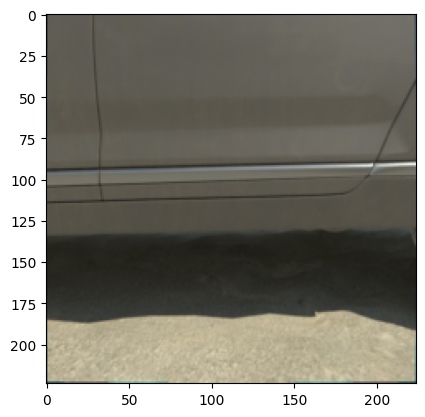

In [ ]:
class CarImageDataset(Dataset):
    def __init__(self, root_dir: str, transform: transforms.Compose = None,
                 split: str = "train", num_folds: int = 10, fold: int = 0,
                 seed: int = 42):
        self.img_dir = os.path.join(root_dir, "imgs")
        self.transform = transform
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
        #        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        self.images = os.listdir(self.img_dir)
        labels = pd.read_csv(os.path.join(root_dir, "car_imgs_4000.csv"))
        self.labels = {row["filename"]: [row["perspective_score_hood"], row["perspective_score_backdoor_left"]] for idx, row in labels.iterrows()}

        # split the data into 10 folds (9 for train/val and 1 for test)
        skf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
        splits = skf.split(list(range(len(self.images))))
        train_val_idx, test_idx = list(splits)[fold]

        # split train/val-split into 9 folds (8 for train and 1 for val)
        skf2 = KFold(n_splits=num_folds-1, random_state=seed, shuffle=True)
        splits2 = skf2.split(list(range(len(train_val_idx))))
        train_idx, val_idx = list(splits2)[0]

        if split == "train":
            self.images = [self.images[i] for i in train_idx]
        elif split == "val":
            self.images = [self.images[i] for i in val_idx]
        elif split == "test":
            self.images = [self.images[i] for i in test_idx]


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(image_path)
        if self.transform:
          image = self.transform(image)
        label = torch.tensor(self.labels[self.images[idx]])

        return image, label

root_dir = "/content/drive/MyDrive/CodingChallenge_v2"
example = CarImageDataset(root_dir)
example_img, example_label = example[0]
print(example_img.shape)
print(example_label)
plt.imshow(example_img.permute(1, 2, 0))
plt.show()


In [ ]:
# function to get dataloaders
def get_dataloaders(root_dir: str, train_transform: transforms.Compose = None, val_transform: transforms.Compose = None, batch_size: int = 16, fold: int = 0):
    train_dataset = CarImageDataset(root_dir=root_dir, transform=train_transform, split="train", fold=fold)
    val_dataset = CarImageDataset(root_dir=root_dir, transform=val_transform, split="val", fold=fold)
    test_dataset = CarImageDataset(root_dir=root_dir, transform=val_transform, split="test", fold=fold)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    return {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}

## Model
Since we are doing a regression task on images, I have decided to implement a simple convolutional neural network (CNN). CNNs are great at deep learning tasks involving pictures as input, e.g. object detection, image classification, or image segmentation. They usually consist of convolutional layers and pooling layers followed by fully connected linear layers to produce the desired output.

In [ ]:
from torch import nn
import torch.nn.functional as F



class CNNImageScorer(nn.Module):
    def __init__(self, img_size: int = 224, num_scores: int = 2):
        super(CNNImageScorer, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        #self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        #self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        fc_size = 128 * (img_size // 4) * (img_size // 4)
        self.fc1 = nn.Linear(fc_size, 1024)
        self.fc2 = nn.Linear(1024, num_scores)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        #x = F.relu(self.conv3(x))
        #x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x


example = CNNImageScorer()
example_input = torch.randn(1, 3, 224, 224)
example_output = example(example_input)
print(example)
print(example_output.shape)

CNNImageScorer(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)
torch.Size([1, 2])


## Training
The following cell implements the training loop for learning the correct weights of our model. The weights are updated based on a given learning rate of **lr=0.001** and the mean-squared-error (**MSE**) loss function.

In [ ]:
import logging
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error


# trainer class implmenting training, validation and testing
class Trainer:
    def __init__(self, dataloaders: dict[DataLoader], hparams: dict, save_dir: str) -> None:
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel(level=logging.INFO)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        id = len(os.listdir(save_dir))
        self.save_path = os.path.join(save_dir, f"model_{id}.pth")

        self.hparams = hparams
        self.epochs = hparams["epochs"]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = CNNImageScorer(img_size=self.hparams["input_size"])
        self.model.to(self.device)
        self.train_dataloader = dataloaders["train"]
        self.val_dataloader = dataloaders["val"]
        self.test_dataloader = dataloaders["test"]
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.hparams["lr"])

        self.logger.info(f"Device: {self.device}")


    def train(self):
        self.model.train()
        self.logger.info("Starting training...")
        for epoch in range(self.epochs):
            self.logger.info(f"Epoch {epoch+1}/{self.epochs}")
            running_loss = 0.0
            for i, (X, y) in enumerate(tqdm(self.train_dataloader)):
                X, y = X.to(self.device), y.to(self.device)

                pred = self.model(X)
                loss = self.loss_fn(pred, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()



            val_loss = self.val()
            self.logger.info(f"Epoch {epoch+1} training loss: {running_loss/len(self.train_dataloader)}")
            self.logger.info(f"Epoch {epoch+1} validation loss: {val_loss}")

        self.save_model()
        self.logger.info("Training completed!")

    def val(self):
        self.model.eval()
        with torch.no_grad():
            running_loss = 0.0
            for i, (X, y) in enumerate(self.val_dataloader):
                X, y = X.to(self.device), y.to(self.device)
                pred = self.model(X)
                loss = self.loss_fn(pred, y)
                running_loss += loss.item()
            return running_loss/len(self.val_dataloader)

    def save_model(self):
        torch.save(self.model.state_dict(), self.save_path)


    def test(self, model_path: str):
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()
        with torch.no_grad():
            running_loss = 0.0
            pred_hood = []
            pred_backdoor = []
            true_hood = []
            true_backdoor = []
            for i, (X, y) in enumerate(self.test_dataloader):
                true_hood.append(y[0,0].item())
                true_backdoor.append(y[0,1].item())
                X, y = X.to(self.device), y.to(self.device)
                pred = self.model(X)
                loss = self.loss_fn(pred, y)
                running_loss += loss.item()
                pred_hood.append(pred.cpu()[0,0].item())
                pred_backdoor.append(pred.cpu()[0,1].item())
                pred_dict = {
                    "Predicted visibility hood": pred.cpu()[0,0].item(),
                    "Predicted visibility left back door": pred.cpu()[0,1].item()
                }
                true_dict = {
                    "True visibility hood": y.cpu()[0,0].item(),
                    "True visibility left back door": y.cpu()[0,1].item()
                }
                self.logger.info(f"Predicted visibility: {pred_dict}")
                self.logger.info(f"True visibility: {true_dict}")
                self.logger.info(f"Test loss: {loss.item()}")

        r2_hood = r2_score(true_hood, pred_hood)
        r2_backdoor = r2_score(true_backdoor, pred_backdoor)
        mse_hood = mean_squared_error(true_hood, pred_hood)
        mse_backdoor = mean_squared_error(true_backdoor, pred_backdoor)
        self.logger.info(f"R2 score for hood: {r2_hood}")
        self.logger.info(f"R2 score for backdoor: {r2_backdoor}")
        self.logger.info(f"MSE for hood: {mse_hood}")
        self.logger.info(f"MSE for backdoor: {mse_backdoor}")
        average_test_loss = running_loss/len(self.test_dataloader)
        self.logger.info(f"Average test MSE: {average_test_loss}")


In [ ]:
root_dir = "/content/drive/MyDrive/CodingChallenge_v2"
save_dir = os.path.join(root_dir, "models")
hparams = {
    "input_size": 224,
    "batch_size": 16,
    "epochs": 10,
    "lr": 0.01,
}
train_transform = transforms.Compose([
                transforms.Resize((hparams["input_size"], hparams["input_size"])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
val_transform = train_transform
dataloaders = get_dataloaders(root_dir, train_transform, val_transform, batch_size=hparams["batch_size"])


trainer = Trainer(dataloaders, hparams, save_dir)
trainer.train()

INFO:Trainer:Device: cpu
INFO:Trainer:Starting training...
INFO:Trainer:Epoch 1/10
 22%|██▏       | 38/174 [06:28<23:09, 10.22s/it]


KeyboardInterrupt: 

In [ ]:
model_path = "/content/model_lr01.pth"
trainer = Trainer(dataloaders, hparams)
trainer.test(model_path)

INFO:Trainer:Device: cuda
<ipython-input-32-156bd2fb693b>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))
INFO:Trainer:P